# Network missing links prediction

The goal of this assigment is to **predict missing links from a network**.

The dataset is a **citation network of research articles, represented as a graph G = (V, E)**. The nodes correspond to scientific articles
and the existence of a directed edge between nodes u and v indicates that paper u cites paper v. Each article is also associated with information such as title, publication year,
author names, journal name and a short abstract.

We will build a **machine learning model to predict from a pair of nodes if an edge is present (1) or not (0)**. A number of edges have been randomly removed from the initial graph, and the binary classifier performance will be measured on a test subset.

## Get the network as a graph

In [162]:
import pandas as pd

training = pd.read_csv('./data/training_set.txt', sep = ' ', header = None)
training.head(3)

,0,1,2
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0


The training set has 3 columns: the first two indicating nodes IDs and the third one if there is a link between the node pair. **The graph is directed: the first node is the source (quoting article) and the second node is the target (quoted article).**

In [163]:
testing = pd.read_csv('./data/testing_set.txt', sep = ' ', header = None)
testing.head(3)

,0,1
0,9807076,9807139
1,109162,1182
2,9702187,9510135


The testing set is similar but does not contain the link presence information, since this is what we want to predict. We also have access to the file `node_information`, containing additional information about the research articles. The file has no Header and columns can be named for the sake of clarity.

We also use id as index, which will make information retrieval easier later.

In [164]:
node_info = pd.read_csv('./data/node_information.csv', header= None)
node_info.columns = ['id', 'pub_year', 'title', 'authors', 'journal_name', 'abstract']
node_info.head(3)

,id,pub_year,title,authors,journal_name,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...


Now that we have everything, we can start to build our network!

We take the IDs from `node_info`, that contains every node of the entire graph (while the other files are just node pairs and would exclude unlinked nodes). We then add the edges from our training set.

A good library to deal with networks is the python package [NetworkX](https://networkx.github.io/). Important for the graph creation: the correct function for this usecase is `DiGraph` and not `Graph` as the network is directed.

In [165]:
import networkx as nx

IDs = [node_id for node_id in node_info.id]

training_list = training.values.tolist() # training dataframe convertion for easy edges list comprehension below
edges = [(node_pair[0], node_pair[1]) for node_pair in training_list if node_pair[2] == 1]

G = nx.DiGraph()
G.add_nodes_from(IDs)
G.add_edges_from(edges)

print("Number of nodes : " + str(G.number_of_nodes()))
print("Number of edges : " + str(G.number_of_edges()))

Number of nodes : 27770
Number of edges : 335130


## Compute the predictors

The graph contains a lot of nodes and edges. Let's create a subset to keep the learning time of our model more laptop-suitable, it shouldn't impact the performance.

In [166]:
import random

training_reduced = training.sample(frac=0.05) # We keep 5%
training_reduced.columns = ['source', 'target', 'Y']

training_reduced.head(3)

,source,target,Y
147524,9603037,9306052,1
331103,9903164,302104,0
396413,301172,9906064,1


Now that the training dataset is ready, time to create our future predictors. We will use the following node descriptive metrics:

- **Degree centrality**: The fraction of nodes of the total graph each node is connected to. We are interested by the *out-degree* centrality of the source node (percentage of papers the article is quoting), and the *in-degree* centrality of the target node (percentage of papers the article is being quoted by).
- **Page ranking**:  The ranking of the node in the graph based on the structure of the incoming links. We are interested in the page ranking of our target.
- **Preferential attachment**: Express the likeliness of a connection between two nodes based on their existing connectiveness. The function is not implemented in NetworkX for directed graph so we define it.
- **HITS algorithm**: Define a Hub and Authority value. A good Hub points to many other nodes, a good Authority is pointed by many Hubs. We are interested in the Hub score for the source, and the Authority score for the target.

In [167]:
# Degree Centrality features
out_degree_centrality = nx.out_degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
training_reduced['source_out_centrality'] = training_reduced.apply(lambda row: out_degree_centrality[row.source],axis=1)
training_reduced['target_in_centrality'] = training_reduced.apply(lambda row: in_degree_centrality[row.target],axis=1)

# Page rank
page_rank = nx.pagerank_scipy(G)
training_reduced['target_pagerank'] = training_reduced.apply(lambda row: page_rank[row.target],axis=1)

# Preferential Attachment
# For a directed graph, is equal to K_out_source * K_in_target with K the number of neighbors. Which is equivalent to multiply the available centralities.
training_reduced['preferencial_attachment'] = training_reduced.apply(lambda row: row.source_out_centrality * row.target_in_centrality,axis=1)

# HITS algorithm
hub_score, authority_score = nx.hits(G)
training_reduced['source_hub_score'] = training_reduced.apply(lambda row: hub_score[row.source],axis=1)
training_reduced['target_authority_score'] = training_reduced.apply(lambda row: authority_score[row.target],axis=1)

In [168]:
training_reduced.head(3)

,source,target,Y,source_out_centrality,target_in_centrality,target_pagerank,preferencial_attachment,source_hub_score,target_authority_score
147524,9603037,9306052,1,0.000720,0.003493,0.000599,2.515830e-06,0.000080,0.000387
331103,9903164,302104,0,0.000900,0.000036,0.000011,3.242049e-08,0.000287,0.000013
396413,301172,9906064,1,0.001224,0.034931,0.001712,4.276911e-05,0.000036,0.002739


There is also a lot of interesting functions for our predictions that are unfortunately not implemented in NetworkX for directed graph. For that reason, we create an undirected version just to compute the following metrics:
- **Jaccard coefficient**: Express the similarity of a pair of nodes.
- **Academic Adar index**: An indication of the similarity between two nodes as well.
- ** Preferential attachment**: As defined by networkx, computed as the multiplication of the nodes degrees.
We keep in mind that this is not perfect and due to the limits of the used library. However it has a significant impact on the performances, for the better.

In [169]:
G_undirected = nx.Graph()
G_undirected.add_nodes_from(IDs)
G_undirected.add_edges_from(edges)

# We need to create a node_pairs feature, for simplified calculation
training_reduced['node_pairs'] =  training_reduced.apply(lambda row: (row.source, row.target) ,axis=1)

In [170]:
# Jaccard coefficient
jaccard_scores = nx.jaccard_coefficient(G_undirected, training_reduced['node_pairs'])
score_list = []
for score in jaccard_scores:
    score_list.append(score[2])
training_reduced['jaccard'] = score_list

In [171]:
# Adar index
adamic_adar_indexes = nx.adamic_adar_index(G_undirected, training_reduced['node_pairs'])
score_list = []
for score in adamic_adar_indexes:
    score_list.append(score[2])
training_reduced['adamic_adar_indexes'] = score_list

In [172]:
# Ressource allocation index
resource_allocation_indexes = nx.resource_allocation_index(G_undirected, training_reduced['node_pairs'])
score_list = []
for score in resource_allocation_indexes:
    score_list.append(score[2])
training_reduced['resource_allocation_indexes'] = score_list

We can also extract a lot of information from the features of `node_info`:
- **Publication year**: A paper cannot quote a more recent paper. We compute the difference between the publication year of the target and the publication year of the source.
- **Title**: Title similarity induce similar topics, and enhance the chances of articles being linked. We use a cosine distance with a BoW approach
- **Abstract**: We follow the same reasoning that for the title.
- **Authors**: Papers sharing authors should have higher chances of being connected. We count the number of common authors.

We tried to create a feature out of the Journal name, but this has not been conclusive.

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

node_info = node_info.set_index('id')

# Publication year
training_reduced['pub_year_difference'] = training_reduced.apply(lambda row: node_info.pub_year[row.source] - node_info.pub_year[row.target] ,axis=1)
training_reduced['pub_year_difference']=training_reduced['pub_year_difference'].where(training_reduced['pub_year_difference'] < 0, -1)

# Title
corpus_title = node_info['title']
vectorizer = TfidfVectorizer(stop_words="english")
TFIDF_title = vectorizer.fit_transform(corpus_title)
training_reduced['title_cosine'] = training_reduced.apply(lambda row: linear_kernel(TFIDF_title[IDs.index(row.source)], TFIDF_title[IDs.index(row.target)])[0][0]  ,axis=1)

# Abstract
corpus = node_info['abstract']
TFIDF = vectorizer.fit_transform(corpus)
training_reduced['abstract_cosine'] = training_reduced.apply(lambda row: linear_kernel(TFIDF[IDs.index(row.source)], TFIDF[IDs.index(row.target)])[0][0]  ,axis=1)

# Authors
node_info['authors'] = node_info['authors'].fillna(value='')
training_reduced['common_authors'] = training_reduced.apply(lambda row: len(set(node_info.authors[row.source].split(",")).intersection(set(node_info.authors[row.target].split(",")))) ,axis=1)

In [174]:
training_reduced.head(3)

,source,target,Y,source_out_centrality,target_in_centrality,target_pagerank,preferencial_attachment,source_hub_score,target_authority_score,node_pairs,jaccard,adamic_adar_indexes,resource_allocation_indexes,pub_year_difference,title_cosine,abstract_cosine,common_authors
147524,9603037,9306052,1,0.000720,0.003493,0.000599,2.515830e-06,0.000080,0.000387,"(9603037.0, 9306052.0)",0.116279,4.287146,0.217096,-1,0.0,0.057321,0
331103,9903164,302104,0,0.000900,0.000036,0.000011,3.242049e-08,0.000287,0.000013,"(9903164.0, 302104.0)",0.047619,0.264726,0.001062,-4,0.0,0.008869,0
396413,301172,9906064,1,0.001224,0.034931,0.001712,4.276911e-05,0.000036,0.002739,"(301172.0, 9906064.0)",0.025407,7.471130,0.999904,-1,0.0,0.074872,0


We now have 13 predictors! Some of them express a certain part of common information, we can see it on the correlation matrix of features as well:

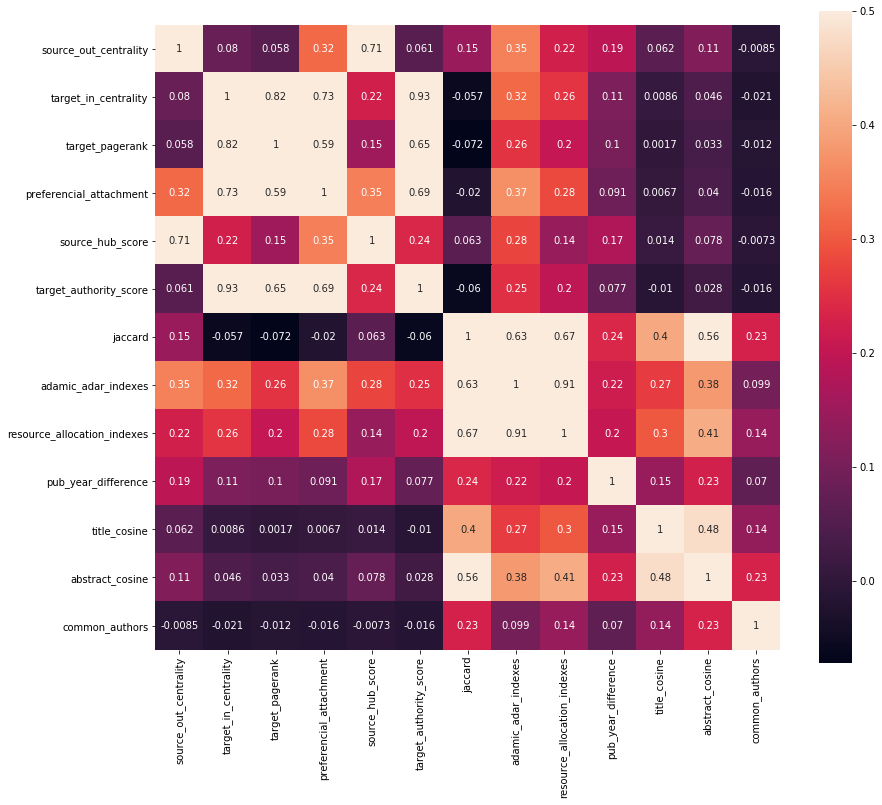

In [175]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))
sns.heatmap(training_reduced.drop(['source', 'target', 'Y'],axis = 1).corr(),
            vmax=0.5,
            square=True,
            annot=True)

Some features have too much collinearity. We remove `target_in_centrality` and `source_out_centrality` that have .82, .71 and .94 with 3 other variables !

In [176]:
training_reduced = training_reduced.drop(['target_in_centrality', 'source_out_centrality'],axis=1)

## Build the model

Even if in the end all of `training_reduced` will be used for training, we first want to create a *train,test split* to have an idea of the performance of the classifier.

### 1. Random Forest classifier

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_reduced.drop(['source', 'target', 'Y', 'node_pairs'], axis= 1), training_reduced.Y, test_size=0.2)

Starting with a Random Forest is often a good idea in this kind of prediction task. Indeed, Random Forest does not require a lot of specific feature engineering, and gives a good idea of important features. We use the [scikit-learn](http://scikit-learn.org/stable/) library.

In [178]:
from sklearn.ensemble import RandomForestClassifier

RF_classifer =  RandomForestClassifier(n_estimators= 100)
RF_classifer.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We now test on our freshly created X_test:

In [179]:
RF_classifer.score(X_test, y_test)

0.97254710851202075

A score of .973 accuracy is very encouraging!
Let us compare this random forest with other classifiers to see which classifier performs best:

### 2. Comparison with other classifiers

In [180]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

names = ["RandomForest","LogisticRegression", "Linear SVM","Nearest Neighbors",
         "Decision Tree", "AdaBoost", "GradientBoosting",
         "Naive Bayes"]

classifiers = [
    RandomForestClassifier(n_estimators= 100),
    LogisticRegression(),
    LinearSVC(),
    KNeighborsClassifier(3),    
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB()]

scores_classifiers_list = []
kfold = model_selection.KFold(n_splits=10, random_state=1)
results= []
for name, classifier in zip(names,classifiers):
    cv_results = model_selection.cross_val_score(classifier, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    dico_class = {}
    dico_class['classifier_name'] = name
    dico_class['mean_accuracy'] = cv_results.mean()
    dico_class['std_accuracy'] = cv_results.std()
    scores_classifiers_list.append(dico_class)
    
df = pd.DataFrame(scores_classifiers_list)
df

,classifier_name,mean_accuracy,std_accuracy
0,RandomForest,0.969456,0.002905
1,LogisticRegression,0.960642,0.004108
2,Linear SVM,0.959058,0.003704
3,Nearest Neighbors,0.962998,0.004112
4,Decision Tree,0.950772,0.002871
5,AdaBoost,0.968237,0.002374
6,GradientBoosting,0.964500,0.004123
7,Naive Bayes,0.953777,0.004008


Random Forest still is the best!

We can try to fit on the entire training set and make the predictions on the test set.To do so, we must reproduce the feature engineering steps previously realized on the training set.

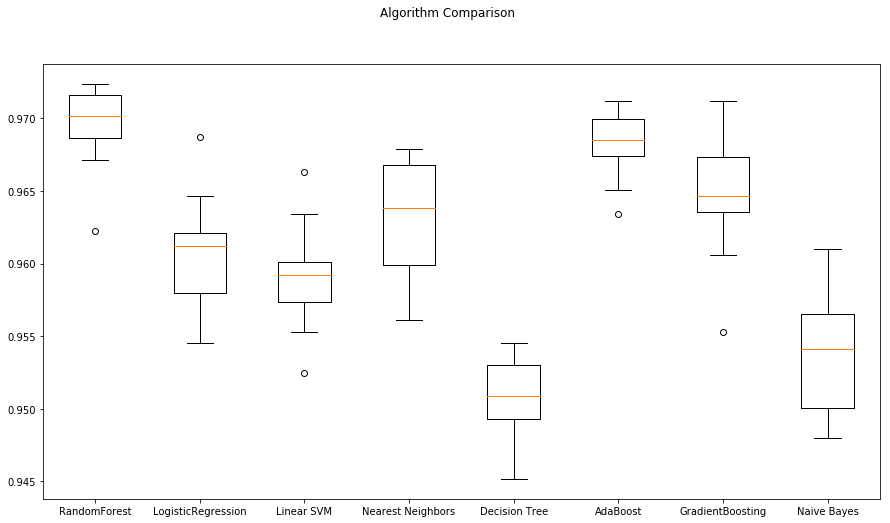

In [181]:
import matplotlib.pyplot as plt
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [182]:
testing.columns = ['source', 'target']

# Degree Centrality features
testing['source_out_centrality'] = testing.apply(lambda row: out_degree_centrality[row.source],axis=1)
testing['target_in_centrality'] = testing.apply(lambda row: in_degree_centrality[row.target],axis=1)
# Page rank
testing['target_pagerank'] = testing.apply(lambda row: page_rank[row.target],axis=1)
# Preferential Attachment
# For a directed graph, is equal to K_out_source * K_in_target with K the number of neighbors. Which is equivalent to multiply the available centralities.
testing['preferencial_attachment'] = testing.apply(lambda row: row.source_out_centrality * row.target_in_centrality,axis=1)
# HITS algorithm
testing['source_hub_score'] = testing.apply(lambda row: hub_score[row.source],axis=1)
testing['target_authority_score'] = testing.apply(lambda row: authority_score[row.target],axis=1)
# Node pairs
testing['node_pairs'] =  testing.apply(lambda row: (row.source, row.target) ,axis=1)
# Jaccard score
jaccard_scores = nx.jaccard_coefficient(G_undirected, testing['node_pairs'])
score_list = []
for score in jaccard_scores:
    score_list.append(score[2])
testing['jaccard'] = score_list
# Adar index
adamic_adar_indexes = nx.adamic_adar_index(G_undirected, testing['node_pairs'])
score_list = []
for score in adamic_adar_indexes:
    score_list.append(score[2])
testing['adamic_adar_indexes'] = score_list
# Ressource allocation index
resource_allocation_indexes = nx.resource_allocation_index(G_undirected, testing['node_pairs'])
score_list = []
for score in resource_allocation_indexes:
    score_list.append(score[2])
testing['resource_allocation_indexes'] = score_list
# Publication year
testing['pub_year_difference'] = testing.apply(lambda row: node_info.pub_year[row.source] - node_info.pub_year[row.target] ,axis=1)
testing['pub_year_difference']=testing['pub_year_difference'].where(testing['pub_year_difference'] < 0, -1)
# Title
testing['title_cosine'] = testing.apply(lambda row: linear_kernel(TFIDF_title[IDs.index(row.source)], TFIDF_title[IDs.index(row.target)])[0][0]  ,axis=1)
# Abstract
testing['abstract_cosine'] = testing.apply(lambda row: linear_kernel(TFIDF[IDs.index(row.source)], TFIDF[IDs.index(row.target)])[0][0]  ,axis=1)
# Authors
testing['common_authors'] = testing.apply(lambda row: len(set(node_info.authors[row.source].split(",")).intersection(set(node_info.authors[row.target].split(",")))) ,axis=1)

In [183]:
RF_classifer =  RandomForestClassifier(n_estimators= 1000)
RF_classifer.fit(training_reduced.drop(['source', 'target', 'Y', 'node_pairs'],axis=1), training_reduced.Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [185]:
testing = testing.drop(['target_in_centrality', 'source_out_centrality'],axis=1)

In [186]:
predictions = RF_classifer.predict(testing.drop(['source', 'target', 'node_pairs'], axis = 1))
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('predictions.csv')

Our predictions have been uploaded to Kaggle and obtained an F1 score of 0.96789! 